In [ ]:
!pip install pytorch_lightning
!pip install tensorboardX
!pip install faiss-gpu-cu11

In [3]:
import pandas as pd
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

from tqdm.autonotebook import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
# import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

import typing as tp
import faiss
from sklearn.metrics.pairwise import euclidean_distances
from functools import partial
import shutil
import random

from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader

np.random.seed(31337)

## Нейросетевой отборщик кандидатов
* Нужен, чтобы быстро найти кандидатов для юзера
* Обучается с помощью лосса, который учитывает близость эмбеддингов, а не скоры

#### Проблема:
Допустим, мы обучаем модель, которая ранжирует кандидатов. Отскорить всех кандидатов в real-time мы сможем за O(N). Это не подходит, если кандидатов очень много. Поэтому будем использовать приближенный поиск соседей (LSH, FAISS etc). При этом соседей мы будем находить по расстоянию между вектором юзера и векторами кандиадтов.

### Решение:
Давайте обучим отдельную модель -- отборщика кандидатов -- которая будет качественно искать ближайших соседей. Для этого смоделируем релевантность с помощью любой метрики, отражающей близость векторов.



In [6]:
track_metadata = pd.read_json("/kaggle/input/recsys-hw/tracks.json", lines=True).drop_duplicates(subset=["track"])

In [7]:
NUM_NG = 4
NUM_NG_TEST = 10
BATCH_SIZE = 256
SEED = 42

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### DSSM:
[DSSM](https://kishorepv.github.io/DSSM/) модель "сближает" эмбеддинги юзера и позитивных айтемов и "раздвигает" эмбеддинги юзера и негативных айтемов.

#### Архитектура:
1.   **ItemModel**: FF нейросеть, которая маппит фичи айтема в латентное пространство модели
2.   **UserModel**: FF нейросеть, которая маппит фичи юзера в латентное пространство модели  
3.   **Loss**: Triplet loss

В кчаестве фичей айтемов будем использовать доступные нам фичи: популярность, жанр. В качестве фичей юзеров будем использовать multi-hot вектора из матрицы интеракций.

Если фичей айтемов и юзеров нет, то можно сделать one-hot кодирование, имея айди юзера и айтемов.


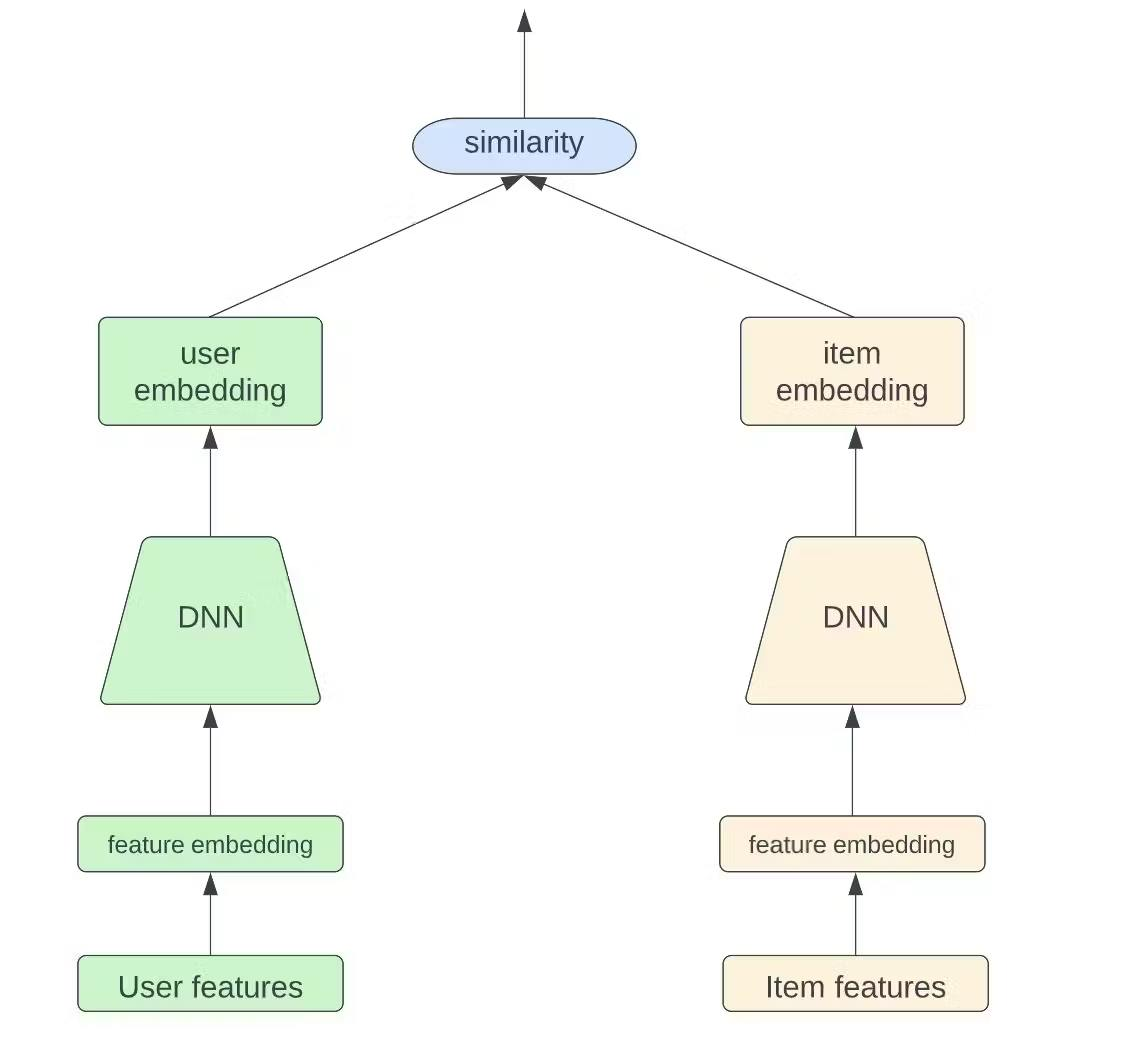

### Triplet loss

$${\displaystyle {\mathcal {L}}\left(A,P,N\right)=\operatorname {max} \left({\|\operatorname {f} \left(A\right)-\operatorname {f} \left(P\right)\|}_{2}-{\|\operatorname {f} \left(A\right)-\operatorname {f} \left(N\right)\|}_{2}+\alpha ,0\right)}$$

${f}(A)$ - эмбеддинг юзера,

${f}(P)$ - эмбеддинг позитивного айтема,

${f}(N)$ - эмбеддинг негативного айтема

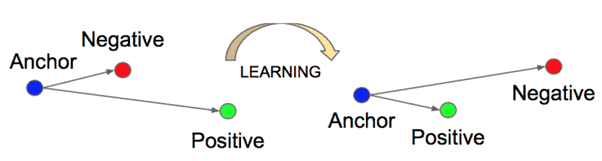

### Сбор данных
* Триплеты: юзер, позитивный айтем, негативный айтем
* Фичи юзера: матрица интеракций
* Фичи айтемов: ohe категориальные фичи

Отберем позитивные интеракции для фичей юзера

In [9]:
track_metadata = pd.read_json("/kaggle/input/recsys-hw/tracks.json", lines=True).drop_duplicates(subset=["track"])

positives = pd.read_json("/kaggle/input/recsys-hw/positives.json", lines=True)

track_counts = positives.groupby("track").size()
tracks = set(track_counts
             [track_counts >= 5]
             .index.values)

data_filt = positives[positives["track"].isin(tracks)]

len(data_filt), len(tracks)

(2400091, 49367)

In [10]:
data_filt

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2025-04-15 18:17:54.456,6293,18320,1.00,0.005177,4519.0,{'PERSONALIZED': 'C'}
1,next,2025-04-15 18:17:54.461,6046,45253,1.00,0.000645,47761.0,{'PERSONALIZED': 'C'}
2,next,2025-04-15 18:17:54.461,619,43110,1.00,0.000363,43557.0,{'PERSONALIZED': 'C'}
3,next,2025-04-15 18:17:54.467,6293,4519,0.80,0.000742,15403.0,{'PERSONALIZED': 'C'}
4,next,2025-04-15 18:17:54.482,7760,15934,0.80,0.000507,14365.0,{'PERSONALIZED': 'C'}
...,...,...,...,...,...,...,...,...
2402054,next,2025-03-18 11:06:19.052,4237,27811,1.00,0.000330,27811.0,{'STICKY_ARTIST': 'T1'}
2402055,next,2025-03-18 11:06:19.060,5705,5694,1.00,0.000405,4819.0,{'STICKY_ARTIST': 'T1'}
2402056,next,2025-03-18 11:06:19.069,9719,6870,0.79,0.000240,6869.0,{'STICKY_ARTIST': 'T1'}
2402057,next,2025-03-18 11:06:19.077,7972,35505,1.00,0.000221,35506.0,{'STICKY_ARTIST': 'T1'}


In [11]:
interactions = pd.pivot_table(data_filt, values="time", index="user", columns="track").fillna(0)

print("Interactions matrix: \nshape=" + str(interactions.shape))
print("Sparsity=" + str((interactions != 0).values.sum() / interactions.size))

Interactions matrix: 
shape=(10000, 49367)
Sparsity=0.00195875584904896


Отберем фичи айтемов: популярность и жанр

In [14]:
track_metadata.shape, track_metadata.isnull().sum(axis = 0)

((50000, 7),
 artist      0
 album       0
 title       0
 genre       0
 pop         0
 duration    0
 track       0
 dtype: int64)

In [15]:
track_metadata = track_metadata.fillna(value={'genre': 'Unk'})

In [16]:
dummy_features = pd.get_dummies(track_metadata["genre"].apply(lambda x: x[0]))

In [17]:
dummies = pd.get_dummies(track_metadata["genre"].explode()).groupby(level=0).sum()

In [18]:
item_features = pd.concat([track_metadata[["track", "pop"]], dummies], axis=1).set_index("track", drop=True)

Соберем трейн сразу по тройкам объектов:

uid, iid_pos, iid_neg

* pos - позитивный айтем из сессиии
* neg - случайный айтем из всего каталога

In [22]:
triplets = data_filt[["user", "track"]].rename(columns={"track": "track_pos"})

In [23]:
NUM_NEGATIVE_SAMPLES = 10
triplets =  pd.concat([triplets] * NUM_NEGATIVE_SAMPLES).sort_index().reset_index(drop=True)
triplets["track_neg"] = np.random.choice(range(50000), len(triplets))

In [24]:
triplets

,user,track_pos,track_neg
0,6293,18320,19639
1,6293,18320,6687
2,6293,18320,43542
3,6293,18320,40189
4,6293,18320,7869
...,...,...,...
24000905,272,10078,27225
24000906,272,10078,34209
24000907,272,10078,12727
24000908,272,10078,26871


Разобьем тройки на train, val, test

In [25]:
rdm = np.random.random(len(triplets))
train_data = triplets[rdm < 0.8]
val_data = triplets[(rdm >= 0.8) & (rdm < 0.9)]
test_data = triplets[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(19200741, 2398726, 2401443)

In [26]:
item_features.shape, interactions.shape

((50000, 92), (10000, 49367))

In [27]:
from random import shuffle

def pad_with_specific_value(lst, size, val):
    lst = list(set(lst))
    shuffle(lst)
    lst = lst[:size]
    return np.pad(lst, (0, size - len(lst)), 'constant', constant_values=(val))

padded_users = triplets.groupby("user").apply(lambda x: (
    pad_with_specific_value(x['track_pos'].tolist(), 30, 50000).tolist()
))

padded_users = padded_users.reindex(range(10000), fill_value=[50000] * 30)
padded_users = np.stack(padded_users.values)

/tmp/ipykernel_31/2212798910.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  padded_users = triplets.groupby("user").apply(lambda x: (


### Создаем датасет для оубчения

Он должен возвращать 3 тензора:

*   user_feaures
*   item_features_pos
*   item_features_neg



In [30]:
class TripletDataset(Dataset):
    def __init__(self,
                 triplets_df: pd.DataFrame,
                 item_features: np.ndarray,
                 padded_users: np.ndarray):
        self.triplets      = triplets_df.reset_index(drop=True)
        self.item_features = torch.from_numpy(item_features).float()
        self.padded_users  = torch.from_numpy(padded_users).long()

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        row     = self.triplets.iloc[idx]
        user_id = int(row.user)
        pos_id  = int(row.track_pos)
        neg_id  = int(row.track_neg)

        user_hist = self.padded_users[user_id]
        feat_pos  = self.item_features[pos_id]
        feat_neg  = self.item_features[neg_id]

        return user_hist, feat_pos, feat_neg

In [31]:
class DSSMDataModule(pl.LightningDataModule):
    """
    LightningDataModule для DSSM:
      - triplets_df: pd.DataFrame с колонками ['user','track_pos','track_neg']
      - item_features: либо np.ndarray (n_items × dim_features), либо pd.DataFrame
      - padded_users:  либо np.ndarray (n_users × history_len), либо pd.DataFrame
    """
    def __init__(self,
                 triplets_df: pd.DataFrame,
                 item_features,
                 padded_users,
                 batch_size: int = 64,
                 num_workers: int = 4,
                 seed: int = 42):
        super().__init__()
        self.triplets_df = triplets_df

        if isinstance(item_features, pd.DataFrame):
            item_features = item_features.values
        if isinstance(padded_users, pd.DataFrame):
            padded_users = padded_users.values

        self.item_features_np = np.asarray(item_features)
        self.padded_users_np  = np.asarray(padded_users)

        self.batch_size  = batch_size
        self.num_workers = num_workers
        self.seed        = seed

        self.train_triplets = None
        self.val_triplets   = None
        self.test_triplets  = None

    def prepare_data(self):
        np.random.seed(self.seed)
        rdm = np.random.random(len(self.triplets_df))

        self.train_triplets = self.triplets_df[rdm < 0.8].reset_index(drop=True)
        self.val_triplets   = self.triplets_df[(rdm >= 0.8) & (rdm < 0.9)].reset_index(drop=True)
        self.test_triplets  = self.triplets_df[rdm >= 0.9].reset_index(drop=True)

    def setup(self, stage=None):
        if stage in (None, 'fit'):
            self.train_dataset = TripletDataset(
                self.train_triplets,
                self.item_features_np,
                self.padded_users_np
            )
            self.val_dataset = TripletDataset(
                self.val_triplets,
                self.item_features_np,
                self.padded_users_np
            )

        if stage in (None, 'test'):
            self.test_dataset = TripletDataset(
                self.test_triplets,
                self.item_features_np,
                self.padded_users_np
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )

### DSSM-модель

In [32]:
class DSSM(pl.LightningModule):
    def __init__(
        self,
        dim_item_features: int,
        item_number: int,
        embedding_dim: int = 100,
        activation: tp.Callable[[torch.Tensor], torch.Tensor] = F.relu,
        lr: float = 1e-3,
        triplet_loss_margin: float = 0.4,
        weight_decay: float = 1e-6,
        log_to_prog_bar: bool = True,
    ) -> None:
        super().__init__()
        self.lr = lr
        self.triplet_loss_margin = triplet_loss_margin
        self.weight_decay = weight_decay
        self.log_to_prog_bar = log_to_prog_bar
        self.item_net = ItemNet(embedding_dim, dim_item_features, activation)
        self.user_net = UserNet(embedding_dim, item_number)

    def forward(
        self,
        user_ids: torch.Tensor,
        item_features_pos: torch.Tensor,
        item_features_neg: torch.Tensor,
    ) -> tp.Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        anchor = self.user_net(user_ids)
        pos = self.item_net(item_features_pos)
        neg = self.item_net(item_features_neg)

        return anchor, pos, neg

    def _step(self, batch, batch_idx, metric, prog_bar=False):
        user_ids, pos, neg = batch
        anchor, positive, negative = self(user_ids, pos, neg)
        loss = F.triplet_margin_loss(anchor, positive, negative, margin=self.triplet_loss_margin)
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def training_step(self, batch: tp.Sequence[torch.Tensor], batch_idx: int) -> torch.Tensor:
        return self._step(batch, batch_idx, "train_loss")

    def validation_step(self, batch: tp.Sequence[torch.Tensor], batch_idx: int) -> torch.Tensor:
        return self._step(batch, batch_idx, "val_loss", self.log_to_prog_bar)

    def test_step(self, batch, batch_idx, prog_bar=False):
        return self._step(batch, batch_idx, "test_loss", self.log_to_prog_bar)

    def inference(self, dataloader: td.DataLoader[tp.Any], mode: str = "item") -> np.ndarray:
        batches = []
        user_ids = []
        if(mode == "user"):
          model = self.user_net
        elif(mode == "item"):
          model = self.item_net
        else:
          raise ValueError(f"Unsupported model {mode}!")

        self.eval()
        for batch in dataloader:
            ids, features = batch
            with torch.no_grad():
                v_batch = model(features.to(self.device))
            batches.append(v_batch)
            user_ids.append(ids)
        vectors = torch.cat(batches, dim=0).cpu().numpy()
        vectors_ids = torch.cat(user_ids, dim=0).cpu().numpy()
        return vectors_ids, vectors

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [33]:
class ItemNet(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 dim_item_features: int, 
                 activation: tp.Callable[[torch.Tensor], torch.Tensor] = F.relu):
        super().__init__()
        G = dim_item_features - 1

        self.embedding_layer = nn.Linear(
            in_features=G,
            out_features=embedding_dim,
            bias=False
        )

        self.output_layer = nn.Linear(
            in_features=1 + embedding_dim,
            out_features=embedding_dim,
            bias=False
        )

        self.activation = activation

    def forward(self, item_features: torch.Tensor) -> torch.Tensor:
        popularity = item_features[:, 0].unsqueeze(1)   
        genre_feats = item_features[:, 1:]            
        genre_emb = self.activation(self.embedding_layer(genre_feats))  
        x = torch.cat([popularity, genre_emb], dim=1)   
        output = self.activation(self.output_layer(x))
        return output
        
class UserNet(nn.Module):
    def __init__(self, n_factors: int, num_embeddings: int, activation: tp.Callable[[torch.Tensor], torch.Tensor] = F.relu) -> None:
        super().__init__()
        self.track_embeddings = nn.EmbeddingBag(num_embeddings+1, n_factors, padding_idx=num_embeddings)
        self.dense_layer = nn.Linear(n_factors, n_factors, bias=False)
        self.output_layer = nn.Linear(n_factors + n_factors, n_factors, bias=False)
        self.activation = activation

    def forward(self, user_tracks: torch.Tensor) -> torch.Tensor:
        interactions_emb = self.track_embeddings(user_tracks)
        features = self.activation(self.dense_layer(interactions_emb))
        x = torch.concat([interactions_emb, features], axis=1)
        output = self.output_layer(x)
        return output

Конфигурируем обучение

In [36]:
data_module = DSSMDataModule(
    triplets_df=triplets,
    item_features=item_features,
    padded_users=padded_users,
    batch_size=512,       
    num_workers=8
)
net = DSSM(dim_item_features=92, item_number=50000, embedding_dim=128).float()

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=30,
    accelerator='cuda',
    devices=1,
    precision="16-mixed",
    log_every_n_steps = 2, 
    accumulate_grad_batches=4,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback,
    ])

In [39]:
trainer.fit(
    net,
    data_module
)

In [40]:
shutil.move(checkpoint_callback.best_model_path, "dssm_10k.ckpt")

In [41]:
best = DSSM.load_from_checkpoint("/kaggle/input/recsys-hw/results (2)/dssm_10k.ckpt", dim_item_features=92, item_number=50000, embedding_dim=128)

Инферим модель

In [42]:
item_features = item_features.sort_index()
items = torch.from_numpy(item_features.index.values)
inf_items = torch.from_numpy(item_features.values).double()
items_ds = td.TensorDataset(items, inf_items)

In [43]:
inf_dl_items = td.DataLoader(items_ds, batch_size=128, shuffle=False, num_workers=1)
track_ids, track_embeddings = best.double().inference(inf_dl_items)

In [44]:
interactions = interactions.sort_index()
user_ids_inf = torch.from_numpy(interactions.index.values)
user_inf_feat = torch.from_numpy(padded_users[interactions.index.values]).long()
user_ds = td.TensorDataset(user_ids_inf, user_inf_feat)

In [45]:
inf_dl_users = td.DataLoader(user_ds, batch_size=128, shuffle=False, num_workers=1)
user_ids, user_embeddings = best.double().inference(inf_dl_users, "user")

In [46]:
track_embeddings.shape, user_embeddings.shape

((50000, 128), (10000, 128))

In [48]:
index_flat = faiss.index_factory(track_embeddings.shape[1], "Flat", faiss.METRIC_L2)

In [49]:
index_flat.add(track_embeddings.astype('float32'))

In [52]:
k = 100
with open("recommendations_dssm_my.json",  "w", encoding="utf-8") as rf, \
     open("dssm_scores_faiss.json","w", encoding="utf-8") as sf:
    for user, user_emb in tqdm(zip(user_ids, user_embeddings), total=len(user_ids)):
        distances, neighbours = index_flat.search(
            user_emb.astype('float32')[np.newaxis, :],
            k
        )
        rec_record = {
            "user":   int(user),
            "tracks": neighbours.flatten().tolist()
        }
        score_record = {
            "user":   int(user),
            "scores": distances.flatten().tolist()
        }

        rf.write(json.dumps(rec_record, ensure_ascii=False) + "\n")
        sf.write(json.dumps(score_record, ensure_ascii=False) + "\n")

  0%|          | 0/10000 [00:00<?, ?it/s]